# Line Finding

In this notebook, I will be working on processing driving images from a car to find where are the road lines.

## Correcting for distorsion

One of the first steps to avoid deformed images is the correction of the distortion created by the lenses of the camera. To calibrate the images we are using chessboard images. These images are taken with the camera, and we know they correspond to squares with a certain size. By computing the points on the original image we can compute the calibration matrix to be used on the images taken by that camera.

In [2]:
import cv2
import glob
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle

%matplotlib inline

In [3]:
TERM_CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

def getImagePoints(images):
    """
    Obtain objpoints and imgpoints from the images.
    """
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    
    objpoints = [] # 3d point in real world space.
    imgpoints = [] # 2d point in image plane.
    
    for imageName in images:
        image = cv2.imread(imageName)
        grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Usin 9x6 grid.
        ret, corners = cv2.findChessboardCorners(grayImage, (9,6), None)
        
        # Only add images if points were found.
        if ret == True:
            objpoints.append(objp)
            # We could also refine the corners with cv2.cornerSubPix before storing them
            corners2 = cv2.cornerSubPix(grayImage, corners, (11,11), (-1,-1), TERM_CRITERIA)
            imgpoints.append(corners2)
            
    return objpoints, imgpoints
            
def store_pickle(objpoints, imgpoints, imgSize):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgSize, None, None)
    pickle_cal = {}
    pickle_cal["mtx"] = mtx
    pickle_cal["dist"] = dist
    
    pickle.dump(pickle_cal, open("results/mtx_dist.p", 'wb'))
    
def undistorted(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def plot_undistorted(images, mtx, dist, num_plots, show_original):
    fig, axs = plt.subplots(num_plots[0], num_plots[1], figsize=(64/num_plots[1], 64/num_plots[1]))
    axs = axs.ravel()
    
    undistorted = []
    
    for i, fname in enumerate(images):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_undistorted = cv2.undistort(img, mtx,dist, None, mtx) #undistorted(img, objpoints, imgpoints)
        if show_original:
            axs[2*i].axis('off')
            axs[2*i].imshow(img)
            i = 2*i+1
        axs[i].axis('off')
        axs[i].imshow(img_undistorted)
        undistorted.append(img_undistorted)
        
    return undistorted


In [4]:
images = glob.glob('camera_cal/calibration*.jpg')

objpoints, imgpoints = getImagePoints(images)
img = cv2.imread(images[0])
img_size = (img.shape[1], img.shape[0])
store_pickle(objpoints, imgpoints, img_size)

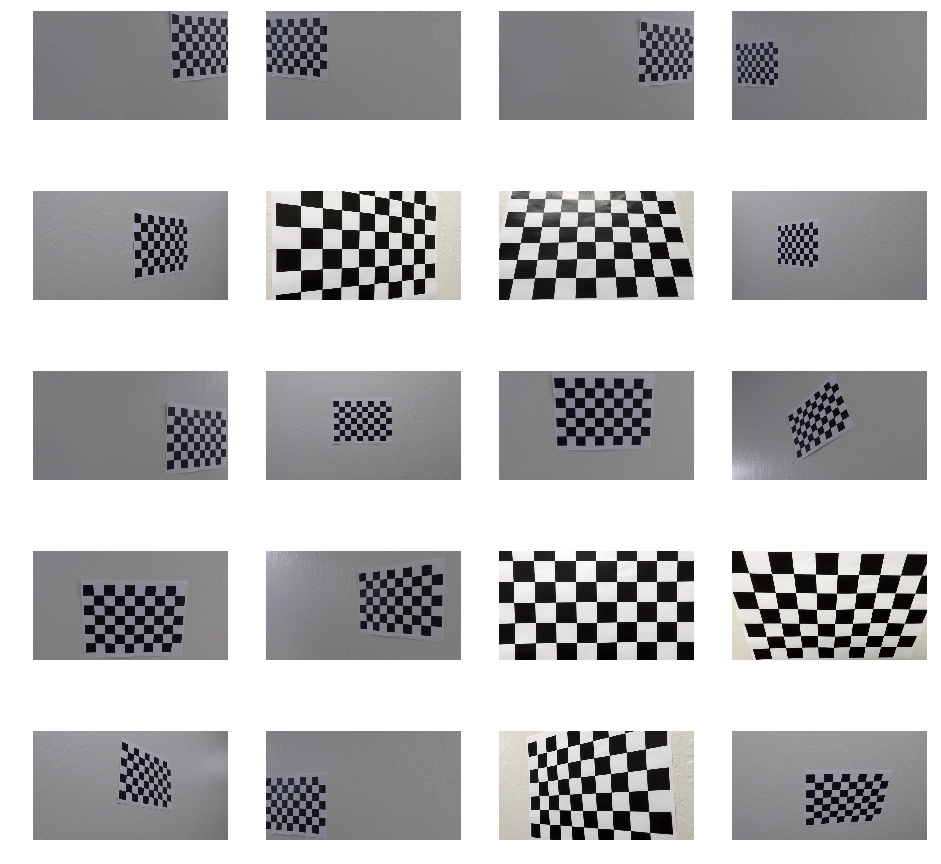

In [5]:
mtx_dist = pickle.load(open("results/mtx_dist.p", "rb"))
_ = plot_undistorted(images, mtx_dist["mtx"], mtx_dist["dist"], (5,4), False)

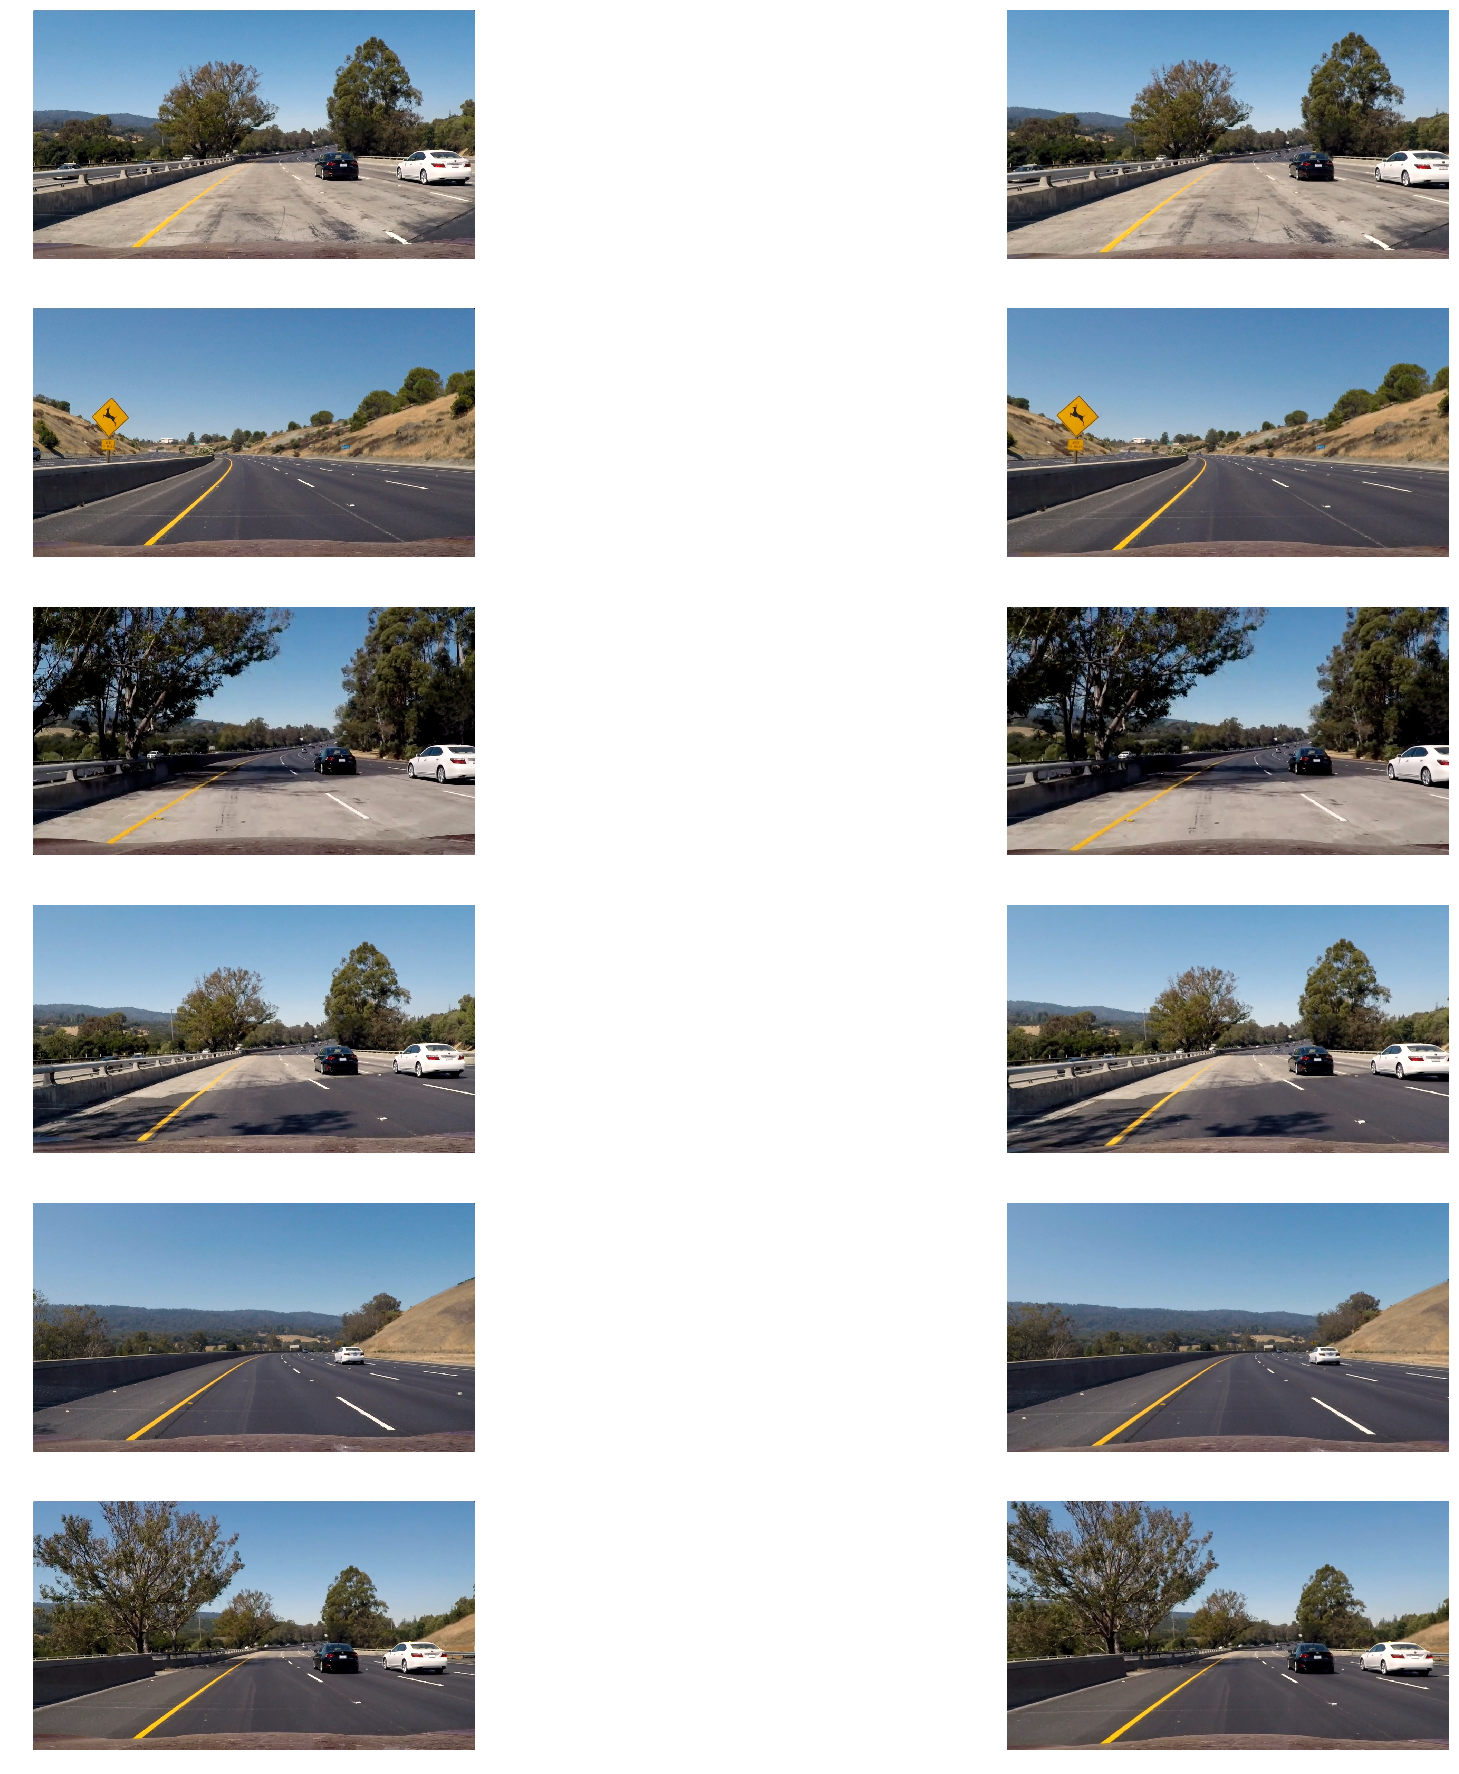

In [6]:
images_test = glob.glob('test_images/test*.jpg')

undistorted_images = plot_undistorted(images_test, mtx_dist["mtx"], mtx_dist["dist"], (6,2), True)

## Create threshold binary image

After the callibration is finished, the next step is to create a thresholded binary image that we can use to delimit the road lanes. To do this, we can use color and gradient threshold.

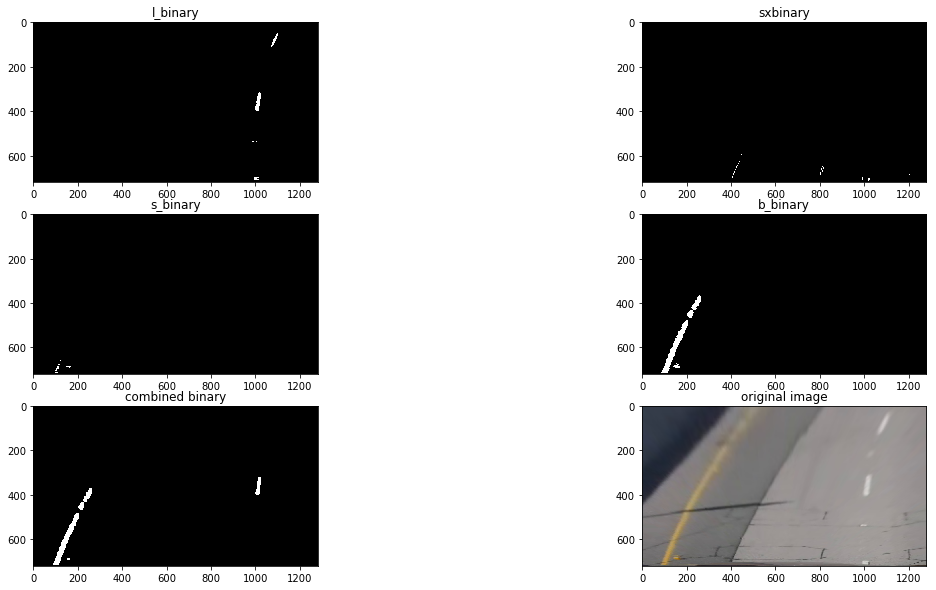

In [104]:
# test_image = undistorted_images[3]
def combined_bin(img):
    """
    Combines different thresholds into an image with the objective of detecting different types of road line separations.
    Returns binary images for each filter used.
    """
    lbinary = l_binary(img)
    sxbinary = sobel_x(img)
    bbinary = b_binary(img)
    sbinary = s_binary(img)
    # sbinary_hsv = s_binary_hsv(s_channel_hsv)

    morphologic = combine(lbinary, sxbinary, sbinary, bbinary)
    
    return lbinary, sxbinary, sbinary, bbinary, morphologic
    
def sobel_x(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    abs_sobel_x = np.absolute(sobel_x)
    scaled_sobel = np.uint(255 * abs_sobel_x / np.max(abs_sobel_x))

    thres_min = 100
    thres_max = 255
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thres_min) & (scaled_sobel < thres_max)] = 1
    
    return sxbinary

def l_binary(img):
    l_thres_min = 200
    l_thres_max = 255
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    l_channel = luv[:,:,0]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thres_min) & (l_channel < l_thres_max)] = 1
    return l_binary

def b_binary(img):
    b_thres_min = 150
    b_thres_max = 255
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thres_min) & (b_channel < b_thres_max)] = 1
    return b_binary

def s_binary(img):
    s_thres_min = 150
    s_thres_max = 255
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    s_channel = hsv[:,:,1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thres_min) & (s_channel < s_thres_max)] = 1
    return s_binary

def s_binary_hsv(img):
    s_thres_min = 200
    s_thres_max = 255
    s_binary_hsv = np.zeros_like(s_channel_hsv)
    s_binary_hsv[(s_channel_hsv >= s_thres_min) & (s_channel_hsv < s_thres_max)] = 1
    
    return s_binary_hsv

def combine(lbinary, sxbinary, sbinary, bbinary):
    combined_binary = np.zeros_like(sxbinary)
    # combined_binary[(sxbinary == 1) | (lbinary == 1) | (sbinary == 1) | (bbinary == 1)] = 1
    combined_binary[(lbinary == 1) | (sbinary == 1) | (bbinary == 1)] = 1
    # Closing morphological operation
    kernel = np.ones((20,20),np.uint8)
    closing = cv2.morphologyEx((1.0*combined_binary).astype(np.float32), cv2.MORPH_CLOSE, kernel)
    
    return closing

def unwarp(img, src, dst):
    """
    unwarp crops the input image (img) using the quadrilater specified in src and maps it to dst (warped). Returns the warped image
    and the matrices to do the transformation to warped and back to unwarped image.
    """
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    h, w = img.shape[:2]

    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

test_image = cv2.imread("test_images/test-challenge/63.jpg")

src = np.float32([(550, 480), (760, 480), (1200, 720), (200,720)])
dst = np.float32([(50, 50), (w-50,50), (w-50,h), (50,h)])

h, w = test_image.shape[:2]
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = undistorted(test_image, mtx_dist["mtx"], mtx_dist["dist"])
test_image, M, Minv = unwarp(test_image, src, dst)

# Testing the different results on a test image.
lbinary, sxbinary, sbinary, bbinary, combined_binary = combined_bin(test_image)

f, axis = plt.subplots(3, 2, figsize = (20,10))
axis = axis.ravel()
axis[0].set_title('l_binary')
axis[0].imshow(lbinary, cmap='Greys_r')

axis[1].set_title('sxbinary')
axis[1].imshow(sxbinary, cmap = 'gray')

axis[2].set_title('s_binary')
axis[2].imshow(sbinary, cmap = 'gray')

axis[3].set_title('b_binary')
axis[3].imshow(bbinary, cmap = 'gray')

axis[4].set_title('combined binary')
axis[4].imshow(combined_binary, cmap = 'gray')

axis[5].set_title('original image')
axis[5].imshow(test_image, cmap = 'gray')

## Perspective transform

Next step is to apply a prespective transform to the binary image to create a birds-eye view of the road. 

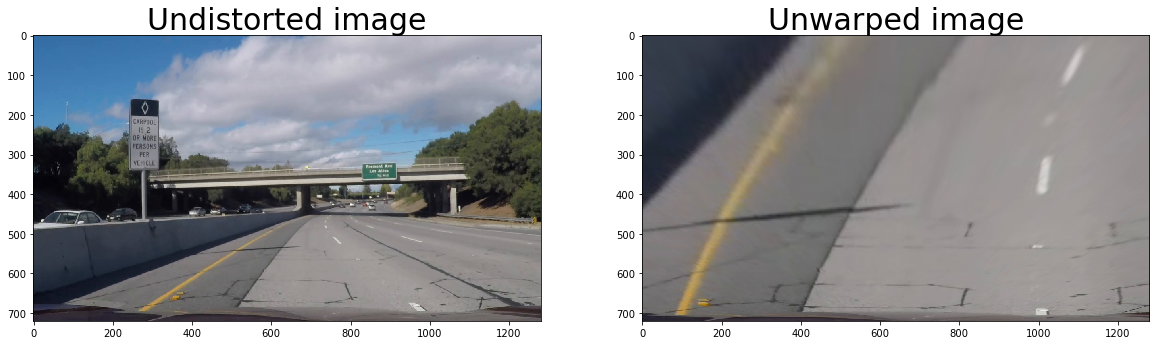

In [102]:
test_image2 = cv2.imread("test_images/test-challenge/63.jpg")
test_image2 = cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB)
test_image = undistorted(test_image2, mtx_dist["mtx"], mtx_dist["dist"])
h,w = test_image2.shape[:2]
test_image_unwarp2, M, Minv = unwarp(test_image2, src, dst)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(test_image2)
ax1.set_title('Undistorted image', fontsize=30)
ax2.imshow(test_image_unwarp2)
ax2.set_title('Unwarped image', fontsize=30)

And we can apply the binary filter to the bird's eye image of the road.

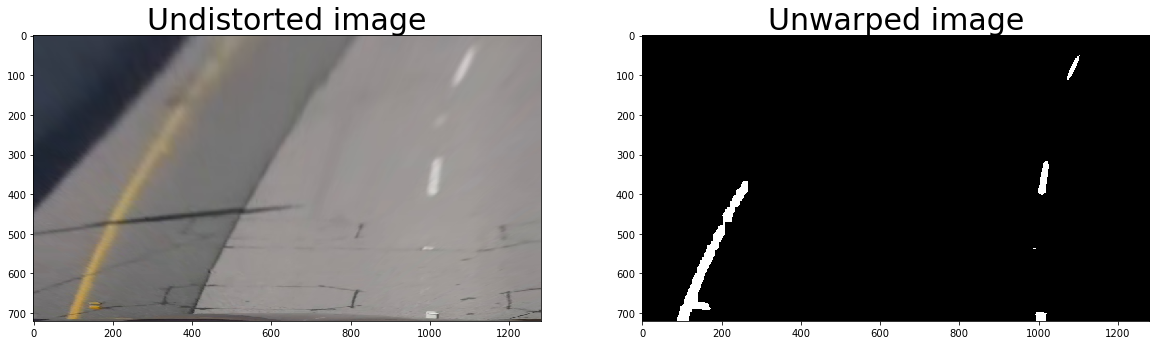

In [14]:
_, _, _, _, combined_binary_unwarp = combined_bin(test_image)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Undistorted image', fontsize=30)
ax2.imshow(combined_binary_unwarp, cmap = 'gray')
ax2.set_title('Unwarped image', fontsize=30)

## Detecting lines
After we have a binary image with some lanes found, we can now work on finding a polynomial line that describes the lanes. To do this, we can use different approaches, but I am using here the Sliding Window polyfit. Probably combining with combolution and taking some sort of average could lead to a more robust detection of lines and line fitting.

In [132]:
def findModes(hist):
    midpoint = np.int(hist.shape[0]/2)
    return np.argmax(hist[:midpoint]), np.argmax(hist[midpoint:]) + midpoint

def get_curverad(x, y):
    x_m = [i * xm_per_pix for i in x]
    y_m = [i * ym_per_pix for i in y]
    fit_cr = np.polyfit(y_m, x_m, 2)
    
    # height of the image.
    y_eval = np.max(719 * ym_per_pix)
    curverad = ((1 + (2 * fit_cr[0] * y_eval + fit_cr[1])**2)**1.5) / np.absolute(2 * fit_cr[0])
    
    return curverad  

In [145]:
def alternative_sliding_window(img, plot_rectangles = False):
    """
    Test method to ensure the sliding window works before passing it to the pipeline.
    """
    histogram = np.sum(img[img.shape[0]//3:,:], axis=0)
    out_img = np.uint8(np.dstack((img, img, img))*255)
    
    left_peak, right_peak = findModes(histogram)
    
    n_windows = 10
    h_window = np.int(img.shape[0]/n_windows)
    
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    leftx_current = left_peak
    rightx_current = right_peak
    
    # Width_window = 2*margin
    margin = 100
    # Minimum number of pixels needed to recenter the window.
    minpix = 50
    
    # Position of the pixels that represent left and right lanes.
    left_lane_inds = []
    right_lane_inds = []
    
    h_img = img.shape[0]
    w_img = img.shape[1]
    
    leftx = []
    lefty = []
    rightx = []
    righty = []
    
    dx_l = 0
    dx_r = 0
    dy = h_window
    
    for i in range(n_windows):
        win_y_low = img.shape[0] - (i+1)*h_window
        win_y_high = img.shape[0] - i*h_window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
       
        if plot_rectangles:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        if len(good_left_inds) > 0:
            leftx.append(np.mean(nonzerox[good_left_inds]))
            lefty.append(np.mean(nonzeroy[good_left_inds]))
            if len(leftx) > 1:
                dx_l = leftx[-1] - leftx[-2]
        elif len(leftx) > 1:
            leftx.append(leftx[-1] + dx_l)
            lefty.append(lefty[-1] - dy)
        if len(good_right_inds) > 0:
            rightx.append(np.mean(nonzerox[good_right_inds]))
            righty.append(np.mean(nonzeroy[good_right_inds]))
            if len(rightx) > 1:
                dx_r = rightx[-1] - rightx[-2]
        elif len(rightx) > 1:
            rightx.append(rightx[-1] + dx_r)
            righty.append(righty[-1] - dy)
            
        if plot_rectangles:
            cv2.circle(out_img, (int(leftx[-1]), int(lefty[-1])), 10, (255,0,0),-1)
            cv2.circle(out_img, (int(rightx[-1]), int(righty[-1])), 10, (0,0,255),-1)
            
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    left_fit, right_fit = (None, None)
    
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        LeftLine.detected = True
        left_curv = get_curverad(leftx, lefty)
        LeftLine.last_curv = left_curv
    else:
        left_fit = np.array([0,0,left_peak])
        LeftLine.detected = False
        left_curv = LeftLine.last_curv
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        RightLine.detected = True
        right_curv = get_curverad(rightx, righty)
        RightLine.last_curv = right_curv
    else:
        right_fit = np.array([0,0,right_peak])
        RightLine.detected = False
        right_curv = RightLine.last_curv
        
    return left_fit, right_fit, out_img, left_curv, right_curv

And we can plot the different windows and lines we use to fit a polynomial to the lines of the road.

In [146]:
# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #polynomial coefficients for the most recent fit
        self.last_fits = []
        self.last_curv = None
        
class SlidingWindow:
    def __init__(self):
        self.n_windows = 10
        self.nonzerox = None
        self.nonzeroy = None
        self.h_img = None
        self.h_window = None
        self.left_peak = None
        self.right_peak = None

left_fit: [  8.64365795e-05  -5.46443051e-01   4.49437927e+02]
right_fit: [  4.65982865e-04  -4.93734897e-01   1.12033902e+03]


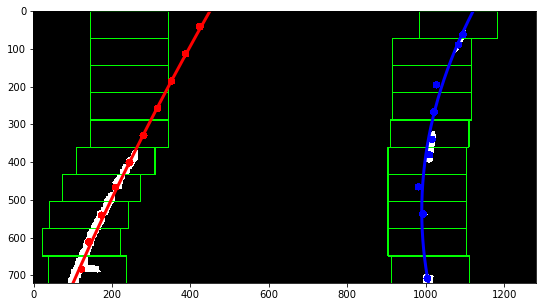

In [147]:
LeftLine = Line()
RightLine = Line()
SlidingHelper = SlidingWindow()

left_fit, right_fit, out_img, _, _ = alternative_sliding_window(combined_binary_unwarp, True)
# left_fit, right_fit, out_img = sliding_window(combined_binary_unwarp, True)

ploty = np.linspace(0, combined_binary_unwarp.shape[0]-1, combined_binary_unwarp.shape[0] )

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

fig, ax = plt.subplots(figsize=(9, 5))
ax.imshow(out_img, aspect='auto')
ax.plot(left_fitx, ploty, color='red', linewidth=3.0)
ax.plot(right_fitx, ploty, color='blue', linewidth=3.0)

print("left_fit: {}".format(left_fit))
print("right_fit: {}".format(right_fit))

In [148]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def sliding_window_pipeline(img):
    histogram = np.sum(img[img.shape[0]//3:,:], axis=0)
    
    sliding_window = SlidingWindow()
    sliding_window.left_peak, sliding_window.right_peak = findModes(histogram)
    sliding_window.h_window = np.int(img.shape[0]/SlidingHelper.n_windows)
    
    nonzero = img.nonzero()
    sliding_window.nonzerox = np.array(nonzero[1])
    sliding_window.nonzeroy = np.array(nonzero[0]) 
    sliding_window.h_img = img.shape[0]
    sliding_window.w_img = img.shape[1]
    
    if LeftLine.detected == False and RightLine.detected == False:
        left_lane_inds, right_lane_inds = find_lanes_inds(sliding_window)
    else:
        margin = 100
        left_lane_inds = ((sliding_window.nonzerox > (LeftLine.current_fit[0]*(sliding_window.nonzeroy**2) + LeftLine.current_fit[1]*sliding_window.nonzeroy + LeftLine.current_fit[2] - margin))
                          & (sliding_window.nonzerox < (LeftLine.current_fit[0]*(sliding_window.nonzeroy**2) + LeftLine.current_fit[1]*sliding_window.nonzeroy + LeftLine.current_fit[2] + margin))) 
        right_lane_inds = ((sliding_window.nonzerox > (RightLine.current_fit[0]*(sliding_window.nonzeroy**2) + RightLine.current_fit[1]*sliding_window.nonzeroy + RightLine.current_fit[2] - margin)) 
                           & (sliding_window.nonzerox < (RightLine.current_fit[0]*(sliding_window.nonzeroy**2) + RightLine.current_fit[1]*sliding_window.nonzeroy + RightLine.current_fit[2] + margin)))  
    
    leftx = sliding_window.nonzerox[left_lane_inds]
    lefty = sliding_window.nonzeroy[left_lane_inds]
    rightx = sliding_window.nonzerox[right_lane_inds]
    righty = sliding_window.nonzeroy[right_lane_inds]

    left_fit, right_fit = (None, None)
    
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        LeftLine.detected = True
        left_curv = get_curverad(leftx, lefty)
        LeftLine.last_curv = left_curv
    else:
        left_fit = LeftLine.current_fit
        LeftLine.detected = False
        left_curv = LeftLine.last_curv
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        RightLine.detected = True
        right_curv = get_curverad(rightx, righty)
        RightLine.last_curv = right_curv
    else:
        right_fit = RightLine.current_fit
        RightLine.detected = False
        right_curv = RightLine.last_curv
    
    return left_fit, right_fit, left_curv, right_curv

def find_lanes_inds(sliding_window):
    # Width_window = 2*margin
    margin = 100
    # Minimum number of pixels needed to recenter the window.
    minpix = 50
      
    # Position of the pixels that represent left and right lanes.
    left_lane_inds = []
    right_lane_inds = []
    
    leftx_current = sliding_window.left_peak
    rightx_current = sliding_window.right_peak
    
    for i in range(sliding_window.n_windows):
        win_y_low = sliding_window.h_img - (i+1)*sliding_window.h_window
        win_y_high = sliding_window.h_img - i*sliding_window.h_window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        good_left_inds = ((sliding_window.nonzeroy >= win_y_low) & (sliding_window.nonzeroy < win_y_high) & (sliding_window.nonzerox >= win_xleft_low) & (sliding_window.nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((sliding_window.nonzeroy >= win_y_low) & (sliding_window.nonzeroy < win_y_high) & (sliding_window.nonzerox >= win_xright_low) & (sliding_window.nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(sliding_window.nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(sliding_window.nonzerox[good_right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    return left_lane_inds, right_lane_inds

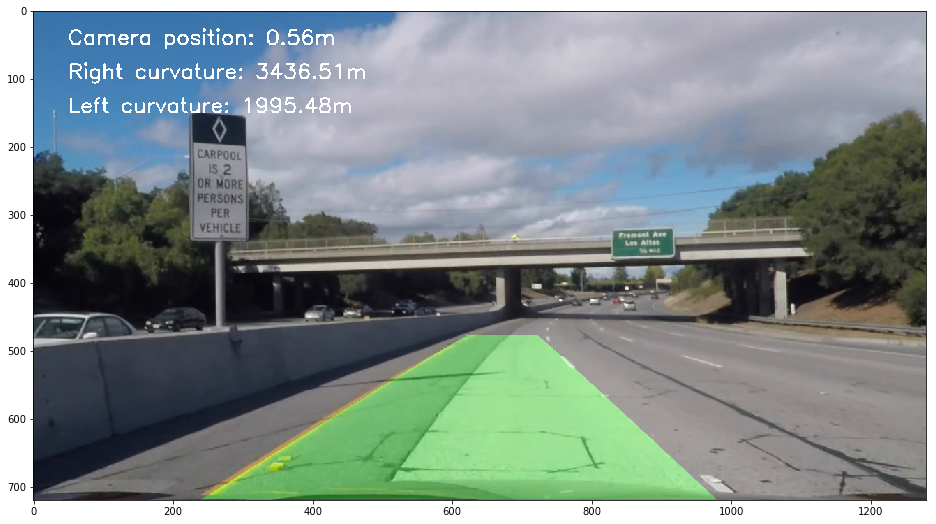

In [149]:
def pipeline(img, printResult=False):
    mtx_dist = pickle.load(open("results/mtx_dist.p", "rb"))
    undist = undistorted(img, mtx_dist["mtx"], mtx_dist["dist"])
    
    h,w = test_image.shape[:2]
    warp, M, Minv = unwarp_pipeline(undist, h, w)
    
    _, _, _, _, binary = combined_bin(warp)
    # left_fit, right_fit, left_rad, right_rad = sliding_window_pipeline(binary)
    left_fit, right_fit, _, left_rad, right_rad = alternative_sliding_window(binary)
    
    if left_fit[2] < right_fit[2]:
        if LeftLine.detected:
            LeftLine.last_fits.append(left_fit)
        if RightLine.detected:
            RightLine.last_fits.append(right_fit)
    
    # Keep the last 10 frames
    LeftLine.last_fits = LeftLine.last_fits[-10:]
    RightLine.last_fits = RightLine.last_fits[-10:]
    
    LeftLine.current_fit = np.mean(LeftLine.last_fits, axis=0)
    RightLine.current_fit = np.mean(RightLine.last_fits, axis=0)

    left_fitx = fit_poly(h, LeftLine.current_fit)
    right_fitx = fit_poly(h, RightLine.current_fit)
    
    # Using closest value of the curve to compute the distance of the car (the car is in the center of the image).
    pos_car = (left_fitx[-1] + right_fitx[-1]) / 2
    
    new_warp = print_lanes(binary, left_fitx, right_fitx, h, w, Minv, pos_car)
    result = cv2.addWeighted(undist, 1, new_warp, 0.3, 0)
    
    print_info(result, pos_car, left_rad, right_rad)
    
    if printResult:
        fig, ax = plt.subplots(figsize=(16, 9))
        ax.imshow(result, aspect='auto')
    
    return result

def unwarp_pipeline(undist, h, w):
    src = np.float32([(550, 480), (760, 480), (1200, 720), (200,720)])
    dst = np.float32([(50, 50),
                  (w-50,50),
                  (w-50,h),
                  (50,h)])
    return unwarp(undist, src, dst)



def fit_poly(max_value, poly):
    y = np.linspace(0, max_value-1, max_value)
    return poly[0]*y**2 + poly[1]*y + poly[2]

def curverad(fit, y_eval):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    return ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0]) * ym_per_pix

def print_lanes(binary, left_fitx, right_fitx, h, w, Minv, pos_car):
    warp_zero = np.zeros_like(binary).astype(np.uint8)
    color_warp = np.uint8(np.dstack((warp_zero, warp_zero, warp_zero))*255)
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    new_warp = cv2.warpPerspective(color_warp, Minv, (w, h))
    
    return new_warp
    
def print_info(result, pos_car, left_rad, right_rad):
    x_m_per_pix = 3.7/700
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Camera position: {:.2f}m'.format((640-pos_car)*x_m_per_pix),(50,50), font, 1,(255,255,255),2)
    cv2.putText(result,'Right curvature: {:.2f}m'.format(right_rad),(50,100), font, 1,(255,255,255),2)
    cv2.putText(result,'Left curvature: {:.2f}m'.format(left_rad),(50,150), font, 1,(255,255,255),2)
    

LeftLine = Line()
RightLine = Line()

# img = cv2.imread("test_images/test/613.jpg")
img = cv2.imread("test_images/test-challenge/63.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            

_ = pipeline(img, True)

In [319]:
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0172032/28549024 bytes (0.6483328/28549024 bytes (1.7696320/28549024 bytes (2.4942080/28549024 bytes (3.31236992/28549024 bytes (4.3%1499136/28549024 bytes (5.3%1728512/28549024 bytes (6.1%1957888/28549024 bytes (6.9%2220032/28549024 bytes (7.8%2465792/28549024 bytes (8.6%2809856/28549024 bytes (9.8%3104768/28549024 bytes (10.93366912/28549024 bytes (11.83579904/28549024 bytes (12.53973120/28549024 bytes (13.94317184/28549024 bytes (15.14644864/28549024 bytes (16.34931584/28549024 bytes (17.35120000/28549024 bytes (17.95251072/28549024 bytes (18.45595136/28549024 bytes (19.65922816/28549024 bytes (20.76234112/28549024 bytes (21.86545408/28549024 bytes (22.96856704/28549024 bytes (24.07102464/28549024 bytes (24.97430144/28549024 bytes (26.07610368/28549024 bytes (26.77

In [41]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [150]:
LeftLine = Line()
RightLine = Line()

output = 'results/output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video results/output.mp4
[MoviePy] Writing video results/output.mp4



 34%|███▍      | 426/1261 [00:43<01:29,  9.38it/s]


 68%|██████▊   | 860/1261 [01:28<00:40,  9.97it/s]


100%|█████████▉| 1260/1261 [02:08<00:00,  9.80it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: results/output.mp4 

CPU times: user 8min 8s, sys: 2.78 s, total: 8min 11s
Wall time: 2min 9s


In [151]:
Left = Line()
Right = Line()

output = 'results/output_challenge.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video results/output_challenge.mp4
[MoviePy] Writing video results/output_challenge.mp4



100%|██████████| 485/485 [00:46<00:00, 10.49it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: results/output_challenge.mp4 

CPU times: user 2min 50s, sys: 968 ms, total: 2min 51s
Wall time: 46.7 s


In [114]:
Left = Line()
Right = Line()

output = 'results/output_harder_challenge.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video results/output_harder_challenge.mp4
[MoviePy] Writing video results/output_harder_challenge.mp4


100%|█████████▉| 1199/1200 [02:01<00:00,  9.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/output_harder_challenge.mp4 

CPU times: user 7min 28s, sys: 3.14 s, total: 7min 31s
Wall time: 2min 2s


In [554]:
output = 'test_images/test-challenge/'
clip1 = VideoFileClip("challenge_video.mp4")

current_num = 0

def store_images(img):
    global current_num
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(output + str(current_num) + ".jpg", img )
    current_num += 1
    return img

white_clip = clip1.fl_image(store_images)
%time white_clip.write_videofile(output + "challenge_video.mp4", audio=False)

[MoviePy] >>>> Building video test_images/test-challenge/challenge_video.mp4
[MoviePy] Writing video test_images/test-challenge/challenge_video.mp4


100%|██████████| 485/485 [00:14<00:00, 34.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_images/test-challenge/challenge_video.mp4 

CPU times: user 27.5 s, sys: 684 ms, total: 28.1 s
Wall time: 14.6 s
